# PHYS20762 - Project - 

David Phelan  
University of Manchester  
March 2025

This project aims to simulate a driven, damped harmonic oscillator.

In [1]:
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Initilisation
import numpy as np
import matplotlib.pyplot as plt
import cmath

The below function is an Euler solution to the equation of motion:

$m \frac{d^2 x(t)}{dt^2} + b \frac{d x(t)}{dt} + kx(t) = F(t),$

where the external force, $F(t)$ is $0$ (not driven) and accepting m, b, and k as inputs.

In [27]:
import numpy as np

def Euler(m, k, b, n, t, x0, v0, dt, push_time, push_force):
    """
    Forward Euler method for a driven (externally forced) oscillator, including
    support for a force applied at t = 0.

    Args:
        m   (float): Mass of the oscillator.
        k   (float): Spring constant.
        b   (float): Damping coefficient.
        n   (int)  : Number of time steps.
        t   (float): Total simulation time.
        x0  (float): Initial position x(0).
        v0  (float): Initial velocity x'(0).
        dt  (float): Time step size.
        push_time (float): The time at which the external force is applied.
        push_force (float): The magnitude of the force applied at `push_time`.

    Returns:
        x (ndarray): Positions at each timestep (length n+1).
        v (ndarray): Velocities at each timestep (length n+1).
        a (ndarray): Accelerations at each timestep (length n+1).
        t (ndarray): Array of time points from 0 to t (length n+1).
    """

    time_array = np.linspace(0, t, n+1)

    # Allocate arrays
    position = np.zeros(n+1)
    velocity = np.zeros(n+1)
    acceleration = np.zeros(n+1)

    # Find the index corresponding to push_time
    push_index = np.argmin(np.abs(time_array - push_time))

    # Determine initial acceleration
    initial_force = push_force if push_time == 0 else 0  # Apply force only if push_time == 0
    acceleration[0] = (initial_force - k * x0 - b * v0) / m  # Apply force at t = 0

    # Initial conditions
    position[0] = x0
    velocity[0] = v0

    # Forward Euler time-stepping
    for i in range(n):
        # Apply external force at the push time (excluding t=0 which was handled already)
        external_force = push_force if (i == push_index and push_time != 0) else 0
        
        # Update velocity using the old acceleration
        velocity[i+1] = velocity[i] + acceleration[i] * dt
        
        # Update position using the old velocity
        position[i+1] = position[i] + velocity[i] * dt
        
        # Update acceleration
        acceleration[i+1] = (external_force - k * position[i+1] - b * velocity[i+1]) / m

    return position, velocity, acceleration, time_array




def Euler_undriven(m, k, b, n, t, x0, v0, dt):
    """
    Forward Euler method for the undriven (possibly damped) oscillator:
        m x''(t) + b x'(t) + k x(t) = 0

    Args:
        m   (float): Mass of the oscillator.
        k   (float): Spring constant.
        b   (float): Damping coefficient (0 for no damping).
        n   (int)  : Number of time steps.
        x0  (float): Initial position x(0).
        v0  (float): Initial velocity x'(0).
        dt  (float): Timestep size.

    Returns:
        x (ndarray): Positions at each timestep (length n+1).
        v (ndarray): Velocities at each timestep (length n+1).
        a (ndarray): Accelerations at each timestep (length n+1).
        t (ndarray): Array of time points from 0 to n*dt (length n+1).

    Notes:
        - This function implements the basic "forward Euler" scheme.
        - The acceleration is computed via a[i+1] = -(k*x[i+1] + b*v[i+1]) / m
          before x[i+1], v[i+1] are updated, matching your original code flow.
        - For purely undamped motion, pass b=0.
    """
    
    time = t
    time_array = np.linspace(0, t, n+1)
    
    # Allocate arrays for position, velocity, and acceleration
    position = np.zeros(n+1)
    velocity = np.zeros(n+1)
    acceleration = np.zeros(n+1)
    
    # Initial conditions
    position[0] = x0
    velocity[0] = v0
    acceleration[0] = -(k * position[0] + b * velocity[0]) / m # Compute initial acceleration at t=0
    
    # Forward Euler time-stepping
    for i in range(n):   
        # Update velocity using the old acceleration
        velocity[i+1] = velocity[i] + acceleration[i] * dt
        
        # Update position using the old velocity
        position[i+1] = position[i] + velocity[i] * dt
    
        # Compute acceleration for the next index (as in your original code)
        acceleration[i+1] = -(k * position[i+1] + b * velocity[i+1]) / m

    return position, velocity, acceleration, time_array
    

Below is code to verify that the Euler function is performing as expected, by checking generated values with expected values using the python keyword assert.

In [4]:
def test_Euler_undriven():
    """
    Tests the Euler_undriven function in simple edge cases
    to confirm that the solver behaves as expected.
    
    Scenario 1: 
        - m=1, k=0, b=0, x0=0, v0=0, dt=0.1
        - Expect no forces and no initial motion => everything remains zero.
    
    Scenario 2:
        - m=1, k=0, b=0, x0=2, v0=-1, dt=0.1
        - Expect velocity remains constant at -1, 
          position decreases linearly with slope -1, 
          acceleration is always zero.
    """
    # -- Scenario 1: no forces and no initial velocity --
    from_module = Euler_driven(m=1, k=0, b=0, x0=0, v0=0, dt=0.1, n=10)
    x_arr, v_arr, a_arr, t_arr = from_module
    
    # Our expected arrays: everything should be zero (length n_stneps+1 = 11)
    zeros_11 = np.zeros(11)
    
    # Assert they match (within floating-point tolerance)
    assert np.allclose(x_arr, zeros_11), "Scenario 1: x should remain zero."
    assert np.allclose(v_arr, zeros_11), "Scenario 1: v should remain zero."
    assert np.allclose(a_arr, zeros_11), "Scenario 1: a should remain zero."
    
    # -- Scenario 2: constant velocity, no forces --
    from_module = Euler_driven(m=1, k=0, b=0, x0=2, v0=-1, dt=0.1, n=10)
    x_arr, v_arr, a_arr, t_arr = from_module
    
    # Time array for reference
    # t_arr = [0.0, 0.1, 0.2, ..., 1.0] (length = 11)
    
    # The velocity should remain at -1:
    expected_v = -1 * np.ones_like(t_arr)
    # The position should be x(t) = 2 + v0 * t = 2 - 1 * t
    expected_x = 2 - t_arr
    # Acceleration should be zero (no spring, no damping)
    expected_a = np.zeros_like(t_arr)
    
    assert np.allclose(v_arr, expected_v),  "Scenario 2: velocity should stay at -1."
    assert np.allclose(x_arr, expected_x),  "Scenario 2: position should be linear in time."
    assert np.allclose(a_arr, expected_a),  "Scenario 2: acceleration should remain zero."
    
    print("All Euler_undriven tests passed successfully!")

#test_Euler_undriven()

The below function is an improved Euler solution to the equation of motion:

$m \frac{d^2 x(t)}{dt^2} + b \frac{d x(t)}{dt} + kx(t) = F(t),$

where the external force, $F(t)$ is $0$ (not driven) and accepting m, b, and k as inputs.

In [5]:
def ImprovedEuler_undriven(m, k, b, n, t, x0, v0, dt):
    """
    Implements the 'Improved Euler' approach shown in the slide:
        x_{i+1} = x_i + h * v_i + 0.5 * h^2 * a_i
        v_{i+1} = v_i + h * a_i
        a_i     = -(k/m)*x_i - (b/m)*v_i

    Args:
        m   : mass
        k   : spring constant
        b   : damping coefficient
        n   : number of time steps
        x0  : initial position
        v0  : initial velocity
        dt  : time step

    Returns:
        x, v, a, t
          x, v, a are arrays of length (n+1);
          t is the array of time points from 0 to n*dt.
    """

    time = t
    time_array = np.linspace(0, t, n+1)
    
    position = np.zeros(n+1)
    velocity = np.zeros(n+1)
    acceleration = np.zeros(n+1)

    # Initial conditions
    position[0] = x0
    velocity[0] = v0
    acceleration[0] = -(k*position[0] + b*velocity[0]) / m  # acceleration at i=0

    for i in range(n):
        # Position update includes a half-step for the acceleration
        position[i+1] = position[i] + dt*velocity[i] + 0.5*(dt**2)*acceleration[i]
        
        # Velocity update is the standard Euler step
        velocity[i+1] = velocity[i] + dt*acceleration[i]

        # Compute the new acceleration at i+1
        acceleration[i+1] = -(k*position[i+1] + b*velocity[i+1]) / m

    return position, velocity, acceleration, time_array

Below is code to verify that the improved Euler function is performing as expected, by checking generated values with expected values using the python keyword assert.

In [6]:
def test_ImprovedEuler_undriven():
    """
    Tests the Improved Euler (2nd-order Taylor) method in simple edge cases:
    
    Scenario 1: 
        k=0, b=0, v0=0 => no force, no initial velocity
        Expected: The mass stays at the initial position, with zero velocity/acceleration.

    Scenario 2: 
        k=0, b=0, v0 != 0 => no force, nonzero initial velocity
        Expected: The mass moves with constant velocity (v0) 
                  so x(t) = x0 + v0 * t, and a(t) = 0.
    """
    
    # -----------------------------
    # Scenario 1: No force, no initial motion
    # -----------------------------
    from_func = ImprovedEuler_undriven(m=1, k=0, b=0, n=10, x0=2, v0=0, dt=0.1)
    x_arr, v_arr, a_arr, t_arr = from_func
    
    # All values should remain exactly the initial position, 
    # with zero velocity and zero acceleration.
    expected_x = np.full_like(t_arr, 2.0)  # always at x=2
    expected_v = np.zeros_like(t_arr)
    expected_a = np.zeros_like(t_arr)
    
    assert np.allclose(x_arr, expected_x), "Scenario 1: position should remain constant at 2."
    assert np.allclose(v_arr, expected_v), "Scenario 1: velocity should remain zero."
    assert np.allclose(a_arr, expected_a), "Scenario 1: acceleration should remain zero."

    # -----------------------------
    # Scenario 2: No force, but nonzero initial velocity
    # -----------------------------
    from_func = ImprovedEuler_undriven(m=1, k=0, b=0, n=10, x0=2, v0=-1, dt=0.1)
    x_arr, v_arr, a_arr, t_arr = from_func
    
    # Velocity should stay at -1, position should decrease linearly
    # x(t) = x0 + v0 * t = 2 - t
    expected_v = -1.0 * np.ones_like(t_arr)
    expected_x = 2.0 + (-1.0)*t_arr
    expected_a = np.zeros_like(t_arr)
    
    assert np.allclose(v_arr, expected_v),  "Scenario 2: velocity should remain constant at -1."
    assert np.allclose(x_arr, expected_x),  "Scenario 2: position should be 2 - t."
    assert np.allclose(a_arr, expected_a),  "Scenario 2: acceleration should remain zero."

    print("All tests for the Improved Euler (2nd-order) method passed successfully!")

#test_ImprovedEuler_undriven()

The below function is an Euler-Cromer solution to the equation of motion:

$m \frac{d^2 x(t)}{dt^2} + b \frac{d x(t)}{dt} + kx(t) = F(t),$

where the external force, $F(t)$ is $0$ (not driven) and accepting m, b, and k as inputs.

In [7]:
def EulerCromer_undriven(m, k, b, n, t, x0, v0, dt):
    """
    Euler–Cromer method for the undriven (possibly damped) oscillator:
        m x'' + b x' + k x = 0

    Updates:
        v_{i+1} = v_i + dt * a_i
        x_{i+1} = x_i + dt * v_{i+1}
    where
        a_i = -(k*x_i + b*v_i) / m.

    Args:
        m   (float): Mass of the oscillator
        k   (float): Spring constant
        b   (float): Damping coefficient (0 for no damping)
        n   (int)  : Number of time steps
        x0  (float): Initial position (x(0))
        v0  (float): Initial velocity (x'(0))
        dt  (float): Timestep size

    Returns:
        x (ndarray): Positions at each timestep (length n+1)
        v (ndarray): Velocities at each timestep (length n+1)
        a (ndarray): Accelerations at each timestep (length n+1)
        t (ndarray): Time points from 0 to n*dt (length n+1)
    """
    
    time = t
    time_array = np.linspace(0, t, n+1)
    print(len(time_array))
   
    position = np.zeros(n+1)
    velocity = np.zeros(n+1)
    acceleration = np.zeros(n+1)

    # Initial conditions
    position[0] = x0
    velocity[0] = v0
    acceleration[0] = -(k*x0 + b*v0) / m

    # Euler–Cromer loop
    for i in range(n):
        # Update velocity using the old acceleration
        velocity[i+1] = velocity[i] + dt*acceleration[i]
        # Update position using the new velocity
        position[i+1] = position[i] + dt*velocity[i+1]
        # Compute the new acceleration at i+1
        acceleration[i+1] = -(k*position[i+1] + b*velocity[i+1]) / m

    return position, velocity, acceleration, time_array

Below is code to verify that the Euler-Cromer function is performing as expected, by checking generated values with expected values using the python keyword assert.

In [8]:
def test_EulerCromer_undriven():
    """
    Tests the Euler-Cromer method in simple edge cases:
    
    1) No force, no initial velocity => the mass should remain at rest.
    2) No force, nonzero initial velocity => the mass moves at constant velocity.
    """
    # --- Scenario 1: No force, no motion ---
    x_arr, v_arr, a_arr, t_arr = EulerCromer_undriven(
        m=1, k=0, b=0, n=10, x0=5, v0=0, dt=0.1
    )
    # Expect position=constant=5, velocity=0, acceleration=0
    expected_x = np.full_like(t_arr, 5.0)
    expected_v = np.zeros_like(t_arr)
    expected_a = np.zeros_like(t_arr)

    assert np.allclose(x_arr, expected_x), "Scenario 1: x should remain at 5."
    assert np.allclose(v_arr, expected_v), "Scenario 1: v should remain 0."
    assert np.allclose(a_arr, expected_a), "Scenario 1: a should remain 0."

    # --- Scenario 2: No force, constant velocity ---
    x_arr, v_arr, a_arr, t_arr = EulerCromer_undriven(
        m=1, k=0, b=0, n=10, x0=5, v0=2, dt=0.1
    )
    # Velocity=2, so x(t)=5 + 2*t, a(t)=0
    expected_v = np.full_like(t_arr, 2.0)
    expected_x = 5 + 2*t_arr
    expected_a = np.zeros_like(t_arr)

    assert np.allclose(v_arr, expected_v), "Scenario 2: velocity should remain 2."
    assert np.allclose(x_arr, expected_x), "Scenario 2: position should be 5 + 2*t."
    assert np.allclose(a_arr, expected_a), "Scenario 2: acceleration should remain 0."

    print("All Euler-Cromer tests passed successfully!")

#test_EulerCromer_undriven()

Verlet

In [9]:
def Verlet_undriven(m, k, b, n, t, x0, v0, dt):
    """
    Two-step method for the undriven (possibly damped) oscillator:
        m x'' + b x' + k x = 0
    using the recurrence relation:
        x_{i+1} = A x_i + B x_{i-1},
    with A, B as in the question. The first step x[1] is computed by
    an improved-Euler-style update for consistency.

    Args:
        m   : Mass of the oscillator
        k   : Spring constant
        b   : Damping coefficient (0 => no damping)
        n   : Number of time steps
        x0  : Initial position, x(0)
        v0  : Initial velocity, x'(0)
        dt  : Timestep size, h

    Returns:
        x, v, a, t
          x (ndarray): positions at each timestep (length n+1)
          v (ndarray): velocities approximated by finite difference (length n+1)
          a (ndarray): accelerations computed from x and v (length n+1)
          t (ndarray): time points from 0..n*dt (length n+1)
    """

    # Precompute constants for the two-step recurrence
    D = 2*m + b*dt
    A = 2.0*(2*m - k*(dt**2)) / D
    B = (b*dt - 2*m) / D

    time = t
    time_array = np.linspace(0, t, n+1)

    position = np.zeros(n+1)
    velocity = np.zeros(n+1)
    acceleration = np.zeros(n+1)

    # Initial conditions
    position[0] = x0
    velocity[0] = v0
    # Acceleration at t=0
    acceleration[0] = -(k*x0 + b*v0)/m

    # -----------------------------------------------------------
    # KICK-START STEP (i=0 --> i=1) using "Improved Euler" (2nd order)
    #
    # x1 = x0 + dt*v0 + 0.5*dt^2 * a0
    # v1 = v0 + dt*a0
    # -----------------------------------------------------------
    position[1] = position[0] + dt*velocity[0] + 0.5*(dt**2)*acceleration[0]
    velocity[1] = velocity[0] + dt*acceleration[0]
    acceleration[1] = -(k*position[1] + b*velocity[1]) / m

    # -----------------------------------------------------------
    # MAIN LOOP: Two-step recurrence for x_{i+1},
    # then derive v_{i+1} and a_{i+1} for consistency
    # -----------------------------------------------------------
    for i in range(1, n):
        # Position update from the two-step formula
        position[i+1] = A*position[i] + B*position[i-1]

        # Approximate velocity via forward difference
        velocity[i+1] = (position[i+1] - position[i]) / dt

        # Compute acceleration from the ODE definition
        acceleration[i+1] = -(k*position[i+1] + b*velocity[i+1]) / m

    return position, velocity, acceleration, time_array


Verlet tests

In [10]:
def test_Verlet_undriven():
    # Case 1: No force, no initial velocity => remain at rest, x=constant
    x_arr, v_arr, a_arr, t_arr = Verlet_undriven(m=1, k=0, b=0, n=10, x0=2, v0=0, dt=0.1)
    assert np.allclose(x_arr, 2), "Position should remain at x=2."
    assert np.allclose(v_arr, 0), "Velocity should stay zero."
    assert np.allclose(a_arr, 0), "Acceleration should be zero."

    # Case 2: No force, constant nonzero velocity => x(t)=x0 + v0*t
    x_arr, v_arr, a_arr, t_arr = Verlet_undriven(m=1, k=0, b=0, n=10, x0=3, v0=1, dt=0.1)
    expected_x = 3 + t_arr*1.0
    assert np.allclose(x_arr, expected_x), "Position should be x0 + v0*t."
    assert np.allclose(v_arr, 1.0), "Velocity should remain constant at 1."
    assert np.allclose(a_arr, 0), "Acceleration should remain zero."
    
    print("All Verlet_undriven tests passed!")

#test_Verlet_undriven()

In [11]:
def analytical_solution(m,k,b,n,t,x0,v0,dt):

    time = t
    omega_damped = cmath.sqrt(4*k*m-b**2)
    A = (b/(2*1j*omega_damped)+1/2)*x0+v0*m/(omega_damped*1j) 
    B = x0-A
    
    exponential_component = np.exp(-b*time/(2*m))
    sinusoidal_component = (A*np.exp(1j*omega_damped*time/(2*m))
                            +B*np.exp(-1j*omega_damped*time/(2*m)))

    return sinusoidal_component * exponential_component

Plotting each method vs analytical solution for no damping

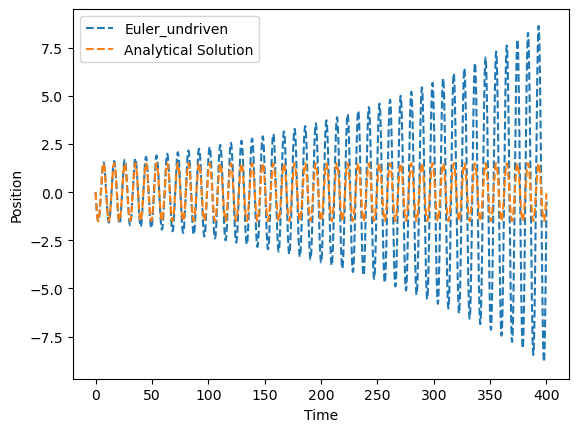

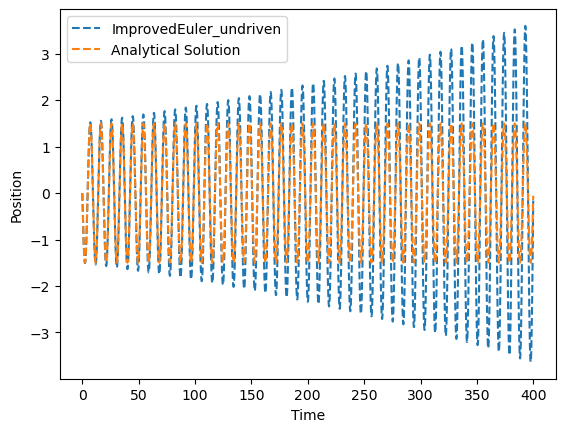

20001


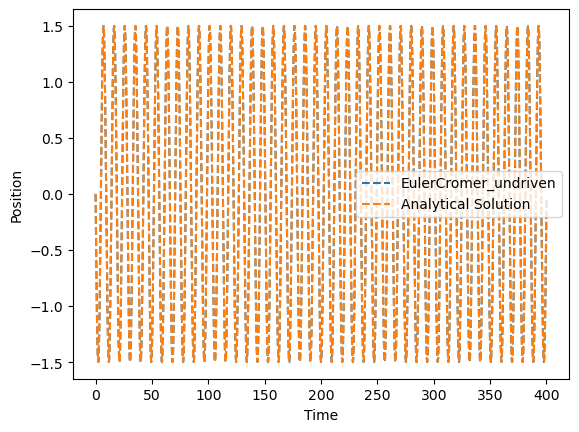

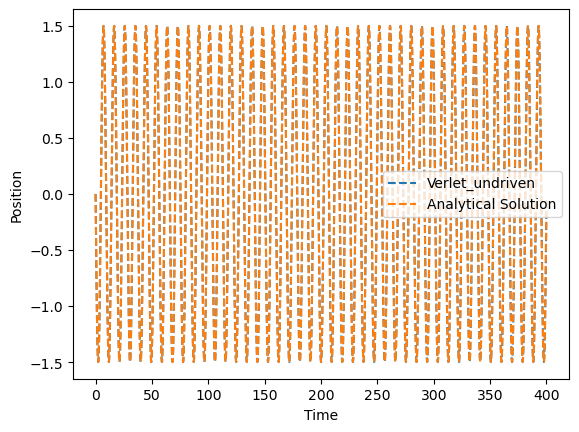

In [28]:
#parameters = [m == 3.03, k == 1.35, b == 0, n == 20000, x0 == 0, v0 == -1, dt == 0.02]

for function in [Euler_undriven, ImprovedEuler_undriven, EulerCromer_undriven, Verlet_undriven]:
    # Parameters
    m = 3.03
    k = 1.35
    b = 0
    n = 20000
    t = 400
    x0 = 0
    v0 = -1
    dt = 0.02

    # Compute the solution
    x, v, a, t = function(m, k, b, n, t, x0, v0, dt)
    a = analytical_solution(m, k, b, n, t, x0, v0, dt)

    # Plot the position vs time
    plt.plot(t, x, label=function.__name__, linestyle='--')
    plt.plot(t, a, label="Analytical Solution", linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()
    plt.show()

Now using different time step values to see effects on each method

In [ ]:
for function in [Euler_undriven, ImprovedEuler_undriven, EulerCromer_undriven, Verlet_undriven]:
    # Parameters
    m = 3.03
    k = 1.35
    b = 0
    n = np.array([20000, 40000, 80000, 160000])
    t = 400
    x0 = 0
    v0 = -1
    dt = t/n
    print(dt)

    plt.figure(figsize=(8, 5))  # Create a new figure for each method

    for n_val, step in zip(n, dt):
        # Compute the solution
        x, v, a, time_array = function(m, k, b, n_val, t, x0, v0, step)

        # Plot the position vs time
        plt.plot(time_array, x, label=f"{function.__name__} (dt={step})", linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()
    plt.show()


The accuracy of Euler and ImprovedEuler greatly improves upon decreasing step size, whereas Euler-Cromer and Verlet are perfectly accurate from the beginning
- can see accuracy improves because the energy no longer diverges but remains more constant as step size decreases (it should be constant for no damping and no external force)
So to investigate further, let's look at how increased damping affects accuracy to explore the further two
Using greatest step size explored earlier since it makes the most accurate solution
For the above graphs - do I want to add the analytical solution? How would I? Clutter?

In [ ]:
for function in [Euler_undriven, ImprovedEuler_undriven, EulerCromer_undriven, Verlet_undriven]:
    # Parameters
    m = 3.03
    k = 1.35
    b = np.array([0, 0.5, 1, 2])
    n = 5000
    t = 100
    x0 = 0
    v0 = -1
    dt = t/n

    plt.figure(figsize=(8, 5))  # Create a new figure for each method

    for b_val in b:
        # Compute the solution
        x, v, a, time_array = function(m, k, b_val, n, t, x0, v0, dt)

        # Plot the position vs time
        plt.plot(time_array, x, label=f"{function.__name__} (b={b_val})", linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.legend()
    plt.show()


Need to say stuff like as you can see, so and so is the most accurate
Problem: why are Euler-Cromer and Verlet identical?

Moving forward with the best chosen method, here it is for a variety of damping coefficients

In [ ]:
# Parameters
m = 3.03
k = 1.35
b_critical = np.sqrt(4*m*k)
b_values = np.array([0, 0.5*b_critical, b_critical, 2*b_critical])
n = 5000
t = 100
x0 = 0
v0 = -1
dt = t/n

plt.figure(figsize=(8, 5))  # Create a new figure for each method

for b in b_values:
    # Compute the solution
    x, v, a, time_array = Verlet_undriven(m, k, b, n, t, x0, v0, dt)

    # Plot the position vs time
    plt.plot(time_array, x, label=f"{Verlet_undriven.__name__} (b={b})", linestyle='--')

plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.show()


Now for analytical
Come back to the below:
Analytical solution graphs, not asked for but I think I should put them alongside the best chosen method when doing different dampings

In [ ]:
'''
# Parameters
m = 3.03
k = 1.35
b_critical = np.sqrt(4*m*k)
b_values = np.array([0, 0.5*b_critical, b_critical, 2*b_critical])
n = 5000
t = 100
x0 = 0
v0 = -1
dt = t/n

plt.figure(figsize=(8, 5))  # Create a new figure for each method
print(len(time_array))

for b in b_values:
    # Compute the solution
    x = analytical_solution(m, k, b, n, time_array, x0, v0, dt)

    # Plot the position vs time
    plt.plot(time_array, x, label=f"{analytical_solution.__name__} (b={b})", linestyle='--')

plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.show()
'''

Discussion here about different damping solutions

Come back to:
We are using analytical methods to check numerical methods for when we can't use analytical . e.g. when F is present
best benchmark is analytical solution
symplectic vs not methods - use symplectic
video 2 has lots of good info (listen not just watch slides)

Questions
If I use extra numerical methods and one is more accurate than the 4 provided, am I okay to use that for the rest of the report?
Talk about errors, watch third video. Maybe plot error (model - analytical values) vs time graph
Do I need to leave a blank like at the end of cells? Like last module wanted
Euler - original vs my method. Can I be calculating a[i+1]? Does that violate Euler principles
Comparing the two test Euler functions I have, why does the new one (with the same logic as far as I can see where F and t_F both = 0) produce a different graph than old one?